# Topic: <span style="color:red">Diabetes Risk Analysis</span>
**Name:** Vu Hoang Nam Doan 

**Student Number:** s224021565

**Email:** s224021565@deakin.edu.au  

**Course:** S379 - Bachelor of Data Science

**Unit:** Undergraduate (SIT220)


## <span style="color:red">Ethical Considerations in Health Data Analysis</span>
While analyzing the NHANES dataset, some important ethical issues came up regarding demographic variables, especially ethnicity:

1. **Avoiding Stereotypes**: When discussing the link between ethnicity and health outcomes, we must clarify that these connections are shaped by complex social factors, not biological differences.

2. **Researcher Responsibility**: We must work to prevent the spread of harmful stereotypes while still recognizing health differences that exist among various communities.

3. **Context Matters**: Any differences in health outcomes between groups should be viewed in relation to social, economic, and historical factors, not seen as traits of the groups themselves.

4. **Protecting Privacy**: Although the NHANES dataset is anonymized, combining various data points may still increase the risk of identifying individuals in small groups.

5. **Clear Visuals**: When creating visuals that include ethnicity data, I made sure that color choices and labels do not support stereotypes.

6. **Purpose Limitation**: The demographic analysis was conducted to demonstrate visualization techniques rather than to make definitive claims about health differences between ethnic groups.

Throughout this analysis, I've attempted to balance the need for comprehensive health analysis with ethical responsibility, recognizing that data scientists play an important role in how demographic health information is interpreted and understood by others.

## Abstract

This report presents a comprehensive analysis of NHANES health data focusing on diabetes risk factors through multiple analytical approaches. After thorough data preparation—including comparative evaluation of imputation techniques with KNN selected for numerical variables and mode imputation for categorical variables—the analysis explores diabetes prevalence across demographic factors through interactive Bokeh visualizations. The investigation employs Random Forest classification to identify and rank key diabetes risk predictors, achieving an AUC score of 0.737, followed by examination of socioeconomic disparities in diabetes rates across income levels. Finally, K-means clustering groups participants into four distinct health profiles based on the elbow method's determination, while Principal Component Analysis reduces data dimensionality to two components capturing 47.60% of variance, enabling effective visualization of relationships between multiple health factors and diabetes risk through interactive scatter plots that integrate both original variables and principal components.

## I. Introduction
This notebook explores the application of the `bokeh` library and its extensions in data analysis and machine learning. `Bokeh` is a powerful tool for creating interactive visualizations, showcasing its capabilities in presenting data effectively. The content is organized into three sections, with a link provided in a code block for easy access.

The report begins by importing a variety of essential Python libraries to facilitate data analysis, visualization, and machine learning, including tools for data manipulation and algorithms like KMeans, PCA, and RandomForest. The primary focus will be on leveraging the `bokeh` library and its extensions, which enhance its functionality for specific tasks, making it an invaluable resource for interactive data visualization in Python.

*The notebook is configured for inline plotting within the Jupyter environment, enabling seamless integration of visualizations with analysis.*

In [5]:
# Standard library imports
import json
import re
import itertools
from pathlib import Path

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Visualization - Matplotlib        
import matplotlib.pyplot as plt

# Visualization - Bokeh
from bokeh.io import output_notebook
from bokeh.models import (
    CDSView, 
    ColumnDataSource, 
    HoverTool, 
    IndexFilter, 
    LabelSet, 
    Range1d, 
    Span
)
from bokeh.palettes import Category10
from bokeh.plotting import figure, show

# Interactive widgets
from ipywidgets import Dropdown, IntSlider, interact
from IPython.display import display

In [ ]:
# %matplotlib inline
output_notebook()

Loading BokehJS ...

## II. Data Ingestion: Selecting Key Variables

In this section, we define the source URLs for accessing NHANES 2021-2023 data files directly from the CDC's website. The National Health and Nutrition Examination Survey (NHANES) is a program of studies designed to assess the health and nutritional status of adults and children in the United States.

Each component dataset is stored in XPT format (SAS transport files), containing specialized health information critical for diabetes risk and health status assessment. The datasets are selected based on their relevance to diabetes risk factors, including demographics, body measurements, glycohemoglobin levels, physical activity, income, diabetes history, and dietary intake.

- **DEMO_L**: Demographics dataset capturing fundamental participant characteristics
  - Age, gender, race/ethnicity variables necessary for population stratification
  - Socioeconomic indicators that may correlate with health outcomes
  - Sampling weights for national population estimates

- **BMX_L**: Body Measurements examining anthropometrics
  - Body Mass Index (BMI) - a key diabetes risk factor
  - Height, weight, and other physical measurements
  - Used to classify participants into weight categories

- **GHB_L**: Glycohemoglobin laboratory results
  - HbA1c percentages - the gold standard biomarker for diabetes
  - Reflects average blood glucose over previous 2-3 months
  - Clinical cutoff ≥6.5% indicates diabetes

- **PAQ_L**: Physical Activity Questionnaire data
  - Self-reported exercise frequency, duration, and intensity
  - Sedentary behavior indicators
  - Essential for evaluating lifestyle contributions to health

- **INQ_L**: Income Questionnaire information
  - Family monthly poverty level index categories
  - Important social determinant of health access and outcomes

- **DIQ_L**: Diabetes Questionnaire responses
  - Self-reported diabetes diagnoses
  - Age at diagnosis, treatment patterns
  - Family history and diabetes awareness

- **DR1TOT_L**: Dietary Recall total nutrients
  - Calorie intake, macronutrient distribution
  - Sugar consumption, dietary patterns
  - Nutritional factors affecting diabetes risk

We establishes a centralized reference dictionary for all NHANES 2021-2023 data files mapping short dataset names to their full URLs. This dictionary implementation improves code readability, ensures consistency across the notebook, and provides a single location for URL updates if newer datasets become available. The XPT files are read directly from the CDC servers, ensuring we're using the most current published versions.

In [8]:
files = {
    "DEMO": 'DEMO_L.XPT',
    "BMX":  'BMX_L.XPT',
    "GHB":  'GHB_L.XPT',
    "PAQ": 'PAQ_L.XPT',
    "INQ": 'INQ_L.XPT',
    "DIQ": 'DIQ_L.XPT',
    "DR1TOT": 'DR1TOT_L.XPT',
}

### A Demographics

Now we will load the demographics data. Rather than importing the entire demographics file (which contains dozens of variables), we extract only four essential identifiers and demographic characteristics needed for our health analysis:

- **SEQN**: The unique participant sequence number that serves as the primary key for linking all NHANES datasets together
- **RIAGENDR**: Gender/sex identification coded as 1 (Male) or 2 (Female)
- **RIDAGEYR**: Age in years at the time of screening
- **RIDRETH1**: Race/ethnicity classification using NHANES standard codes (1-5)

These demographic data categoric columns has specific codes, we will use the following dictionaries to convert them to human-readable strings. Here are the tables for the codes

- The gender of the respondent

| RIAGENDR | Gender of the respondent |
|----------|------------------------- |
| 1        | Male                     |
| 2        | Female                   |
| .        | Missing                  |

- The ethnicity of the respondent

| RIDRETH1 | Ethnicity of the respondent        |
|----------|---------------------------         |
| 1        | Mexican American                              |
| 2        | Other Hispanic                     |
| 3        | Non-Hispanic White                 |
| 4        | Non-Hispanic Black                 |
| 5        | Other Race - Including Multi-Racial|
| .       | Missing                             |

The `pd.read_sas()` function directly reads the SAS XPT (transport) file format that NHANES provides from the CDC files we defined earlier. By passing the column list as an indexer `[demo_columns]`, we efficiently load only the subset of variables needed

The print statement confirms successful data retrieval by displaying the dimensions of the loaded dataset - specifically how many participants (rows) and variables (columns) were imported. This demographic information will later be merged with other NHANES components like body measurements, laboratory results, and questionnaire responses to create a comprehensive dataset for diabetes risk analysis.

In [10]:
demo_columns = ["SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH1"]
demo = pd.read_sas(files["DEMO"], format="xport")[demo_columns]
print(f"DEMO: loaded {len(demo)} rows, {len(demo.columns)} columns")


DEMO: loaded 11933 rows, 4 columns


Afterwards, we perform essential exploratory data analysis (EDA) on the newly loaded demographics dataset. It provides a comprehensive overview of the data structure, contents, and quality through three key components:

1. **Shape Output**: Displays the dimensions of the DataFrame as `(rows, columns)`, showing exactly how many participants are in the NHANES sample

2. **DataFrame Info**: Provides a concise summary of the dataset structure, including name, data types, and non-null counts for each column

3. **Data Preview**: Displays the first 5 rows of raw data using `head()` to observe the format and values of the loaded dataset

In [12]:
print("Shape:", demo.shape)
print("\nInfo:")
demo.info()
print("\nPreview:")
demo.head()

Shape: (11933, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   RIAGENDR  11933 non-null  float64
 2   RIDAGEYR  11933 non-null  float64
 3   RIDRETH1  11933 non-null  float64
dtypes: float64(4)
memory usage: 373.0 KB

Preview:


,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1
0,130378.0,1.0,43.0,5.0
1,130379.0,1.0,66.0,3.0
2,130380.0,2.0,44.0,2.0
3,130381.0,2.0,5.0,5.0
4,130382.0,1.0,2.0,3.0


Before we merge, we standardize variable names across all our component tables so that downstream code is clear and uniform.

We rename:
- `RIDAGEYR` → `age`  
- `RIAGENDR` → `gender`  
- `RIDRETH1` → `ethnicity`


In [14]:
demo = demo.rename(columns={
    'RIDAGEYR':  'age',
    'RIAGENDR':  'gender',
    'RIDRETH1':  'ethnicity'
})
print("Demo columns:", demo.columns.tolist())

Demo columns: ['SEQN', 'gender', 'age', 'ethnicity']


Then we perform the data type conversions for demographics variables, optimizing both storage and analytical operations by:

1. Transforming `age` from its original floating-point representation to integer
   - Removes unnecessary decimal places (since age in years is discrete)
   - Speeds up calculations by using a more appropriate data type

2. Using pandas' `category` data type for `ethnicity` and `gender`

3. Using `.cat.codes` to return zero-based integer category codes, adding 1 to codes maintains consistency with original NHANES coding standards

In [16]:
demo['age'] = demo['age'].astype(int)
demo['ethnicity'] = demo['ethnicity'].astype('category').cat.codes + 1
demo['gender'] = demo['gender'].astype('category').cat.codes + 1

display(demo)

,SEQN,gender,age,ethnicity
0,130378.0,1,43,5
1,130379.0,1,66,3
2,130380.0,2,44,2
3,130381.0,2,5,5
4,130382.0,1,2,3
...,...,...,...,...
11928,142306.0,1,9,2
11929,142307.0,2,49,4
11930,142308.0,1,50,2
11931,142309.0,1,40,2


For better readability, we should convert the numeric demographic codes into meaningful human-readable categories. This step requires a two-step process to make the demographic data more interpretable while maintaining efficient storage:

1. Creating `eth_map` for the standard NHANES ethnicity/race classifications, connecting numeric codes (1-5) to their descriptive labels and `gender_map` for the binary gender mapping from numeric codes to text labels

2. Using the `.map()` method transforms each numeric code to its corresponding text label

The mapping follows the official NHANES documentation standards for demographic variable coding, ensuring consistency with CDC data definitions while making the data more accessible for downstream analysis.

In [18]:
eth_map = {
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    5: 'Other Race - Including Multi-Racial'
}

gender_map = {
    1: 'Male',
    2: 'Female',
}


demo['ethnicity'] = demo['ethnicity'].map(eth_map)
demo['ethnicity'] = demo['ethnicity'].astype('category')

demo['gender'] = demo['gender'].map(gender_map)
demo['gender'] = demo['gender'].astype('category')

### B. Body Measures
Now we will load the body measures data. This is a large file, so we will only load the columns we need. The columns we need are:

- **SEQN**: Respondent sequence number
- **BMXBMI**: Body Mass Index (BMI) of the respondent

BMI is a key anthropometric measure calculated as weight(kg)/height(m)² that serves as an important indicator for weight status classification. This measurement is particularly relevant for our health analysis as:

- It's strongly associated with diabetes risk and other metabolic conditions
- It allows us to categorize participants into clinically meaningful weight groups (underweight, normal, overweight, obese)
- It's a standardized measure that accounts for both height and weight

The BMX component dataset contains numerous physical measurements, but we extract only BMI to minimize memory usage while obtaining this critical health predictor.

In [20]:
bmx_columns = ["SEQN", "BMXBMI"]
bmx = pd.read_sas(files["BMX"], format="xport")[bmx_columns]
print(f"BMX: loaded {len(bmx)} rows, {len(bmx.columns)} columns")

BMX: loaded 8860 rows, 2 columns


Similar to the demographics dataset, we use `pd.read_sas()` to read the body measures data directly from the CDC website. We pass the column list as an indexer `[bmx_columns]` to efficiently load only the subset of variables needed.

In [22]:
print("Shape:", bmx.shape)
print("\nInfo:")
bmx.info()
print("\nPreview:")
bmx.head()

Shape: (8860, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    8860 non-null   float64
 1   BMXBMI  8471 non-null   float64
dtypes: float64(2)
memory usage: 138.6 KB

Preview:


,SEQN,BMXBMI
0,130378.0,27.0
1,130379.0,33.5
2,130380.0,29.7
3,130381.0,23.8
4,130382.0,NaN


For better readability, we should convert the numeric demographic codes into meaningful human-readable categories.

We rename:
- `BMXBMI` → `bmi`

In [24]:
bmx = bmx.rename(columns={
    'BMXBMI': 'bmi'
})
print("BMX columns:", bmx.columns.tolist())

BMX columns: ['SEQN', 'bmi']


### C. Glycohemoglobin
Now we load glycohemoglobin (HbA1c) measurements - the clinical gold standard for diabetes diagnosis and monitoring. This blood test reflects average blood glucose levels over the previous 2-3 months and is critical for our health status assessment:

- **SEQN**: Respondent sequence number (primary key for linkage)
- **LBXGH**: Glycohemoglobin percentage (HbA1c level)

HbA1c is especially valuable for our analysis because:

- It provides a precise, standardized measure of glycemic control
- Values ≥6.5% are diagnostic for diabetes according to clinical guidelines
- Values between 5.7% and 6.4% indicate prediabetes
- Unlike fasting glucose tests, it reflects longer-term blood sugar management

As with previous datasets, we efficiently extract only the needed variables from the much larger NHANES laboratory component file.

In [26]:
ghb_columns = ["SEQN", "LBXGH"]
ghb = pd.read_sas(files["GHB"], format="xport")[ghb_columns]
print(f"GHB: loaded {len(ghb)} rows, {len(ghb.columns)} columns")


GHB: loaded 7199 rows, 2 columns


Similar to the demographics dataset, we observe the shape of the loaded dataset, confirming successful data retrieval by displaying the dimensions of the loaded dataset.

In [28]:
print("Shape:", ghb.shape)
print("\nInfo:")
ghb.info()
print("\nPreview:")
ghb.head()

Shape: (7199, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    7199 non-null   float64
 1   LBXGH   6715 non-null   float64
dtypes: float64(2)
memory usage: 112.6 KB

Preview:


,SEQN,LBXGH
0,130378.0,5.6
1,130379.0,5.6
2,130380.0,6.2
3,130386.0,5.1
4,130387.0,5.9


We rename the glycohemoglobin variable to a more descriptive name that reflects its clinical significance.

We rename:
- `SEQN` → `SEQN` (keep as is)
- `LBXGH` → `glycohemoglobin`

In [30]:
ghb = ghb.rename(columns={
    'LBXGH': 'glycohemoglobin'
})
print("GHB columns:", ghb.columns.tolist())

GHB columns: ['SEQN', 'glycohemoglobin']


### D. Physical Activity

We now efficiently extract key physical activity metrics from the NHANES Physical Activity Questionnaire (PAQ) component. We target eight essential variables that capture both moderate and vigorous activity patterns along with sedentary behavior:

- **SEQN**: Unique participant identifier enabling data linkage
- **PAD790Q/PAD790U**: Frequency and time unit of moderate activity (e.g., 3 times per week)
- **PAD800**: Average duration (minutes) of each moderate activity session
- **PAD810Q/PAD810U**: Frequency and time unit of vigorous activity
- **PAD820**: Average duration (minutes) of each vigorous activity session
- **PAD680**: Daily time spent in sedentary activities (minutes)

The physical activity variables are particularly valuable for health assessment because:

2. **Time dimensionality**: Records both frequency (how often) and duration (how long)
3. **Sedentary behavior**: Tracks inactivity, which has independent health effects beyond exercise
4. **Time unit flexibility**: Accommodates various reporting patterns (daily, weekly, monthly)

Like previous dataset imports, we use `pd.read_sas()` with column filtering to obtain all variables needed for comprehensive physical activity assessment. The selected variables will be processed into standardized weekly activity metrics that are essential predictors for diabetes risk modeling.


In [32]:
paq_columns = ["SEQN", "PAD790Q", "PAD790U", "PAD800", "PAD810Q", "PAD810U", "PAD820", "PAD680"]
paq = pd.read_sas(files["PAQ"], format="xport")[paq_columns]
print(f"Diet: loaded {len(paq)} rows, {len(paq.columns)} columns")


Diet: loaded 8153 rows, 8 columns


We then observe the shape of the loaded dataset, confirming successful data retrieval by displaying the dimensions of the loaded dataset.

In [34]:
print("Shape:", paq.shape)
print("\nInfo:")
paq.info()
print("\nMissing counts:")
print(paq.isna().sum())
print("\nPreview:")
paq.head()

Shape: (8153, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8153 entries, 0 to 8152
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SEQN     8153 non-null   float64
 1   PAD790Q  8135 non-null   float64
 2   PAD790U  8153 non-null   object 
 3   PAD800   6390 non-null   float64
 4   PAD810Q  8139 non-null   float64
 5   PAD810U  8153 non-null   object 
 6   PAD820   3687 non-null   float64
 7   PAD680   8138 non-null   float64
dtypes: float64(6), object(2)
memory usage: 509.7+ KB

Missing counts:
SEQN          0
PAD790Q      18
PAD790U       0
PAD800     1763
PAD810Q      14
PAD810U       0
PAD820     4466
PAD680       15
dtype: int64

Preview:


,SEQN,PAD790Q,PAD790U,PAD800,PAD810Q,PAD810U,PAD820,PAD680
0,130378.0,3.000000e+00,b'W',45.0,3.000000e+00,b'W',45.0,360.0
1,130379.0,4.000000e+00,b'W',45.0,3.000000e+00,b'W',45.0,480.0
2,130380.0,1.000000e+00,b'W',20.0,5.397605e-79,b'',NaN,240.0
3,130384.0,5.397605e-79,b'',NaN,5.397605e-79,b'',NaN,60.0
4,130385.0,1.000000e+00,b'D',90.0,1.000000e+00,b'W',60.0,180.0


We can see the raw data of the data set needs cleaning and preprocessing, especially for the numerical and unit variables. We rename the physical activity variables to more descriptive names that reflect their content and purpose.

In [36]:
paq = paq.rename(columns={
    'PAD790Q': 'mode_freq',
    'PAD790U': 'mode_unit',
    'PAD800':  'mode_min',
    'PAD810Q': 'vig_freq',
    'PAD810U': 'vig_unit',
    'PAD820':  'vig_min',
    'PAD680':  'sed_min'
})
print("PAQ columns:", paq.columns.tolist())

PAQ columns: ['SEQN', 'mode_freq', 'mode_unit', 'mode_min', 'vig_freq', 'vig_unit', 'vig_min', 'sed_min']


We then identify and properly handle missing value codes in the physical activity dataset. In NHANES studies, missing values are often encoded with special numeric codes rather than actual nulls, which can severely distort statistical analyses if not properly addressed.

We performs the following operations

1. Identifies common NHANES missing value codes (7777 and 9999) that typically represent:
   - 7777: Refused to answer
   - 9999: Don't know/Cannot determine

2. Systematically converts these special codes to proper `np.nan` values across all physical activity numeric columns.


In [38]:
miss_codes = [7777, 9999]
for col in ['mode_freq','mode_min','vig_freq','vig_min','sed_min']:
    paq[col] = paq[col].replace(miss_codes, np.nan)

print("After recode, missing counts:")
print(paq.isna().sum())

After recode, missing counts:
SEQN            0
mode_freq      67
mode_unit       0
mode_min     1782
vig_freq       54
vig_unit        0
vig_min      4480
sed_min        88
dtype: int64


We must handle data transformation for preparing the time unit variables in the physical activity dataset. In this step, we perform some important following operations:

1. Converting the SAS-encoded byte strings to human-readable UTF-8 text using `.str.decode('utf-8')` because time units initially appear as byte literals (e.g., `b'D'`, `b'W'`) rather than plain text characters

2. Transforming the string columns to pandas' efficient `category` data type because these columns contain a small, fixed set of values (D=daily, W=weekly, M=monthly, Y=yearly)

The time unit fields are critical contextual information for calculating standardized activity metrics, as they determine how frequency values should be interpreted (e.g., "3 times per week" vs "3 times per day"). This transformation ensures that we can correctly interpret and standardize physical activity measurements across all participants, regardless of their reporting timeframe.

In [40]:
paq['mode_unit'] = paq['mode_unit'].str.decode('utf-8')
paq['vig_unit'] = paq['vig_unit'].str.decode('utf-8')
paq['mode_unit'] = paq['mode_unit'].astype('category')
paq['vig_unit'] = paq['vig_unit'].astype('category')


Next we have to perform a vital data validation on the physical activity time units. After the previous step converted byte strings to text, this validation ensures only standard time period codes are preserved:

1. **Defines a controlled vocabulary** of valid time units:
   - `'D'` - Daily measurements
   - `'W'` - Weekly measurements  
   - `'M'` - Monthly measurements
   - `'Y'` - Yearly measurements

2. **Applies conditional replacement** using the `.where()` method, which:
   - Preserves values that appear in the valid_units list
   - Replaces any other values with pandas' `pd.NA` marker
   - Creates explicit missing values rather than leaving invalid data

This validation step is essential because:

1. **Prevents calculation errors** - Downstream code that converts frequencies to a standard weekly basis (using multipliers like 7 for daily, 1/4.345 for monthly) would produce meaningless results with invalid unit codes

2. **Improves data quality** - By handling unexpected or corrupted unit codes consistently

3. **Makes missingness explicit** - Distinguishes between true missing values and invalid entries

4. **Maintains data integrity** - Ensures that only standardized, interpretable time units are used in subsequent analyses

The properly validated unit codes will be essential for calculating standardized activity metrics in the later feature engineering stages.

In [42]:
valid_units = ['D','W','M','Y']

paq['mode_unit'] = paq['mode_unit'].where(paq['mode_unit'].isin(valid_units), pd.NA)
paq['vig_unit'] = paq['vig_unit'].where(paq['vig_unit'].isin(valid_units), pd.NA)


After that, we check the missing value of those columns.

In [44]:
print("After decode, missing counts:")
print(paq.isna().sum())

After decode, missing counts:
SEQN            0
mode_freq      67
mode_unit    1763
mode_min     1782
vig_freq       54
vig_unit     4467
vig_min      4480
sed_min        88
dtype: int64


We can see that the missing value of the columns `mode_unit` and `vig_unit` are similar to the documentation of the dataset from the CDC website. Now we check the whole dataset for the missing value. We will extrasct the columns that have more than 30% missing value.

In [46]:
missing_paq = paq.isna().mean().sort_values(ascending=False)
print("Missing fraction per column:\n", missing_paq)

to_drop = missing_paq[missing_paq > 0.30].index.tolist()
print("\nColumns to drop (>30% missing):", to_drop)

Missing fraction per column:
 vig_min      0.549491
vig_unit     0.547896
mode_min     0.218570
mode_unit    0.216239
sed_min      0.010794
mode_freq    0.008218
vig_freq     0.006623
SEQN         0.000000
dtype: float64

Columns to drop (>30% missing): ['vig_min', 'vig_unit']


Then we will drop those columns.

In [48]:
paq.drop(columns=to_drop, inplace=True)

Because the `vig_unit` and `vig_min` columns are dropped, we can drop the `vig_freq` column as well.

In [50]:
paq.drop(columns=['vig_freq'], inplace=True)

### E. Income Data Processing

This section extracts and processes socioeconomic data from the NHANES Income Questionnaire (INQ_L), focusing on:

- **Poverty-to-Income Ratio**: A standardized measure comparing household income to poverty thresholds
- **Social Determinants of Health**: Economic factors that influence health outcomes and healthcare access

We load only the essential columns:
- `SEQN`: Unique participant identifier for cross-dataset linkage  
- `INDFMMPC`: Family monthly poverty level index categories, stratified as:

| Code | Economic Status | Description |
|------|----------------|-------------|
| 1    | Low Income     | Monthly poverty level ratio ≤ 1.30 |
| 2    | Middle Income  | Monthly poverty level ratio 1.30-1.85 |
| 3    | High Income    | Monthly poverty level ratio > 1.85 |

This poverty-to-income ratio provides crucial context for analyzing health disparities in diabetes prevalence, as numerous studies have demonstrated that socioeconomic status significantly influences:

- Access to healthcare services
- Quality of available nutrition
- Lifestyle choices (e.g., physical activity, smoking)
- Health literacy and awareness

Later in our analysis, this categorical variable will be mapped to more descriptive labels and used to examine how economic factors correlate with diabetes risk and management.


In [52]:
inq_columns = ["SEQN", "INDFMMPC"]
inq = pd.read_sas(files["INQ"], format="xport")[inq_columns]
print(f"Income: loaded {len(inq)} rows, {len(inq.columns)} columns")


Income: loaded 11933 rows, 2 columns


Similar to the previous datasets, we observe the shape of the loaded dataset, confirming successful data retrieval by displaying the dimensions of the loaded dataset.

In [54]:
print("Shape:", inq.shape)
print("\nInfo:")
inq.info()
print("\nPreview:")
inq.head()

Shape: (11933, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   INDFMMPC  10464 non-null  float64
dtypes: float64(2)
memory usage: 186.6 KB

Preview:


,SEQN,INDFMMPC
0,130378.0,3.0
1,130379.0,3.0
2,130380.0,2.0
3,130381.0,1.0
4,130382.0,3.0


First we need to convert the `INDFMMPC` column to a categorical data type. This conversion is important because it allows us to efficiently store and manipulate categorical data, which is particularly useful for variables with a limited number of distinct values.

In [56]:
inq['INDFMMPC'] = inq['INDFMMPC'].astype('category')

Then we rename the `INDFMMPC` column to `monthly_income_category` to make it more descriptive and meaningful.

In [58]:
inq = inq.rename(columns={
    'INDFMMPC': 'monthly_income_category'
})
print("INQ columns:", inq.columns.tolist())

INQ columns: ['SEQN', 'monthly_income_category']


### F. Diabetes

This section loads diabetes diagnosis information from the NHANES Diabetes Questionnaire (DIQ_L).

- **SEQN**: Unique participant identifier that serves as the primary key for merging datasets
- **DIQ010**: Response to the question "Has a doctor ever told you that you have diabetes?"

DIQ010 uses the following coding system:
| Code | Interpretation |
|------|----------------|
| 1    | Yes - diagnosed with diabetes |
| 2    | No |
| 3    | Borderline/Prediabetes |
| 9    | Don't know/refused (treated as missing) |

This diagnosis data will later be combined with laboratory glycohemoglobin (HbA1c) measurements to create a comprehensive diabetes status variable that can identify both:

- Diagnosed cases (self-reported)
- Undiagnosed cases (normal self-report but elevated HbA1c ≥6.5%)
- Prediabetes (HbA1c between 5.7-6.4%)

In [60]:
diq_columns = ["SEQN", "DIQ010"]
diq = pd.read_sas(files["DIQ"], format="xport")[diq_columns]
print(f"Income: loaded {len(diq)} rows, {len(diq.columns)} columns")


Income: loaded 11744 rows, 2 columns


We again observe the shape and info of the loaded dataset.

In [62]:
print("Shape:", diq.shape)
print("\nInfo:")
diq.info()
print("\nPreview:")
diq.head()

Shape: (11744, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11744 entries, 0 to 11743
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    11744 non-null  float64
 1   DIQ010  11740 non-null  float64
dtypes: float64(2)
memory usage: 183.6 KB

Preview:


,SEQN,DIQ010
0,130378.0,2.0
1,130379.0,2.0
2,130380.0,1.0
3,130381.0,2.0
4,130382.0,2.0


We then rename the column `DIQ010` to `diagnosed` to make it more descriptive and meaningful.

In [64]:
diq = diq.rename(columns={
    'DIQ010': 'diagnosed'
})
print("DIQ columns:", diq.columns.tolist())

DIQ columns: ['SEQN', 'diagnosed']


As we see at the begining, the column has some code for the missing value. We will convert those codes to `np.nan` values, then convert the column to a categorical data type.

In [66]:
diq['diagnosed'] = diq['diagnosed'].replace(9.0, np.nan)
diq['diagnosed'] = diq['diagnosed'].astype('category')


### G. Day 1 Interview - Nutrient Intake
Now we will load the day 1 interview nutrient intake data.  This is a large file, so we will only load the columns we need.  The columns we need are:
- SEQN: Respondent sequence number
- DR1TKCAL: Total energy intake in kilocalories
- DR1TCARB: Total carbohydrate intake in grams 
- DR1TTFAT: Total fat intake in grams
- DR1TSUGR: Total sugar intake in grams

These dietary components are critical for diabetes risk assessment because:

- Caloric balance affects weight management and metabolic health
- Carbohydrate quantity and quality impacts blood glucose regulation
- Sugar intake is directly linked to diabetes risk
- Fat consumption patterns influence insulin sensitivity

When combined with demographic and clinical data, these nutritional variables will help identify dietary patterns associated with different diabetes risk profiles and provide insights into potential lifestyle interventions.

In [68]:
dr1tot_columns = ["SEQN", "DR1TKCAL", "DR1TCARB", "DR1TSUGR", "DR1TTFAT"]
dr1tot = pd.read_sas(files["DR1TOT"], format="xport")[dr1tot_columns]
print(f"Income: loaded {len(dr1tot)} rows, {len(dr1tot.columns)} columns")

Income: loaded 8860 rows, 5 columns


We then observe the shape of the loaded dataset.

In [70]:
print("Shape:", dr1tot.shape)
print("\nInfo:")
dr1tot.info()
print("\nPreview:")
dr1tot.head()

Shape: (8860, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8860 non-null   float64
 1   DR1TKCAL  6694 non-null   float64
 2   DR1TCARB  6694 non-null   float64
 3   DR1TSUGR  6694 non-null   float64
 4   DR1TTFAT  6694 non-null   float64
dtypes: float64(5)
memory usage: 346.2 KB

Preview:


,SEQN,DR1TKCAL,DR1TCARB,DR1TSUGR,DR1TTFAT
0,130378.0,1740.0,169.66,43.71,55.07
1,130379.0,2741.0,314.86,113.58,67.18
2,130380.0,1995.0,281.67,114.66,65.38
3,130381.0,1676.0,224.98,117.83,63.57
4,130382.0,1222.0,194.30,112.99,39.80


The column names in the nutrient intake dataset are quite easy to understand, but we will rename them to make them more descriptive and meaningful.

We rename:
- `DR1TKCAL`: `k_calories`,
- `DR1TCARB`: `carb`,
- `DR1TSUGR`: `sugar`,
- `DR1TTFAT`: `fat`

In [72]:
dr1tot = dr1tot.rename(columns={
    'DR1TKCAL': 'k_calories',
    'DR1TCARB': 'carb',
    'DR1TSUGR': 'sugar',
    'DR1TTFAT': 'fat'
})
print("Diet columns:", dr1tot.columns.tolist())

Diet columns: ['SEQN', 'k_calories', 'carb', 'sugar', 'fat']


## III. Merge All Key Datasets

We join our seven cleaned tables on the respondent identifier `SEQN`.  We use an **inner** merge to keep only participants who have data in all domains to minimize the number of extra missing values.

We will merge all the cleaned tables into one table.  We will use the `pd.merge()` function to do this.  We will merge on the `SEQN` column.  We will use an inner join to keep only participants who have data in all domains.

In [74]:
data = (
    demo
    .merge(bmx, on='SEQN', how='inner')
    .merge(ghb, on='SEQN', how='inner')
    .merge(paq, on='SEQN', how='inner')
    .merge(inq, on='SEQN', how='inner')
    .merge(diq, on='SEQN', how='inner')
    .merge(dr1tot, on='SEQN', how='inner')
)

Now we will check the shape of the merged dataset like the previous sections of loading data.

In [76]:
print("Shape:", data.shape)
print("\nInfo:")
data.info()
print("\nPreview:")
data.head()

Shape: (6337, 16)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337 entries, 0 to 6336
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   SEQN                     6337 non-null   float64 
 1   gender                   6337 non-null   category
 2   age                      6337 non-null   int32   
 3   ethnicity                6337 non-null   category
 4   bmi                      6235 non-null   float64 
 5   glycohemoglobin          6002 non-null   float64 
 6   mode_freq                6299 non-null   float64 
 7   mode_unit                5031 non-null   category
 8   mode_min                 5018 non-null   float64 
 9   sed_min                  6290 non-null   float64 
 10  monthly_income_category  5817 non-null   category
 11  diagnosed                6336 non-null   category
 12  k_calories               4986 non-null   float64 
 13  carb                     4986 non-null

,SEQN,gender,age,ethnicity,bmi,glycohemoglobin,mode_freq,mode_unit,mode_min,sed_min,monthly_income_category,diagnosed,k_calories,carb,sugar,fat
0,130378.0,Male,43,Other Race - Including Multi-Racial,27.0,5.6,3.000000e+00,W,45.0,360.0,3.0,2.0,1740.0,169.66,43.71,55.07
1,130379.0,Male,66,Non-Hispanic White,33.5,5.6,4.000000e+00,W,45.0,480.0,3.0,2.0,2741.0,314.86,113.58,67.18
2,130380.0,Female,44,Other Hispanic,29.7,6.2,1.000000e+00,W,20.0,240.0,2.0,1.0,1995.0,281.67,114.66,65.38
3,130386.0,Male,34,Mexican American,30.2,5.1,1.000000e+00,W,30.0,180.0,2.0,2.0,2422.0,207.53,37.89,116.54
4,130387.0,Female,68,Non-Hispanic White,42.6,5.9,5.397605e-79,NaN,NaN,1200.0,2.0,2.0,3849.0,376.54,227.99,234.39


We can see that we have 6337 rows and 16 columns. This means that we have 6337 participants with data in all domains.

## IV. Data Cleaning

### A. Merged Data Final Clean Up
We will now perform some final clean up on the merged dataset.

Observing the display of the merged dataset, we can see that the column `mode_freq` has some values less than 1, which is not possible for the frequency of an activity.  We will set those values to `np.nan`. This step is crucial because later we will analyze the imputation of the missing values and their impact on the overall dataset. Cleaning this column's invalid values ensures that our analysis is based on accurate and meaningful data, which is essential for drawing valid conclusions about the relationships between physical activity and health outcomes.

In [81]:
data['mode_freq'] = data['mode_freq'].mask(data['mode_freq'] < 1, np.nan)

After that, we will copy the merged dataset to a new variable called `clean_data` to avoid modification in the original dataset. This copied dataset will be used for all further analysis and modeling, including the imputation step.


In [83]:
clean_data = data.copy()
display(clean_data.head())

,SEQN,gender,age,ethnicity,bmi,glycohemoglobin,mode_freq,mode_unit,mode_min,sed_min,monthly_income_category,diagnosed,k_calories,carb,sugar,fat
0,130378.0,Male,43,Other Race - Including Multi-Racial,27.0,5.6,3.0,W,45.0,360.0,3.0,2.0,1740.0,169.66,43.71,55.07
1,130379.0,Male,66,Non-Hispanic White,33.5,5.6,4.0,W,45.0,480.0,3.0,2.0,2741.0,314.86,113.58,67.18
2,130380.0,Female,44,Other Hispanic,29.7,6.2,1.0,W,20.0,240.0,2.0,1.0,1995.0,281.67,114.66,65.38
3,130386.0,Male,34,Mexican American,30.2,5.1,1.0,W,30.0,180.0,2.0,2.0,2422.0,207.53,37.89,116.54
4,130387.0,Female,68,Non-Hispanic White,42.6,5.9,NaN,NaN,NaN,1200.0,2.0,2.0,3849.0,376.54,227.99,234.39


### B Impute Numeric Columns

There're various imputation method for missing values but they can lead to different statistical measurement. To determine the most appropriate method, we have to try each of them and compare the data distribution. In this section, we will try 3 imputation methods to fill in the missing values in the numeric columns. We will use the `SimpleImputer` class from the `sklearn.impute` module to do this. The three imputation methods we will try are:
- Mean
- Median
- KNN

The mean and median imputation methods are simple and fast, but they can introduce bias into the data. The KNN imputation method is more complex and slower, but it can provide better results in some cases. KNN imputation uses the K-nearest neighbors algorithm to find the most similar observations in the dataset and uses their values to fill in the missing values. This method can be more accurate than mean or median imputation, especially when the data is not normally distributed.

First, we define the list of numeric columns that we want to impute.  We will use the `select_dtypes()` method to select only the numeric columns from the dataset.

In [85]:
numeric_cols = data.select_dtypes(include=['float64','int32']).columns
print(numeric_cols)

Index(['SEQN', 'age', 'bmi', 'glycohemoglobin', 'mode_freq', 'mode_min',
       'sed_min', 'k_calories', 'carb', 'sugar', 'fat'],
      dtype='object')


After that, we then extract the numeric columns from the dataset and store them in a new variable called `numeric_data`.  We will use this variable to perform the imputation.

In [87]:
numeric_data = clean_data[numeric_cols].copy()

Now we will define the imputation methods we want to use.  We will use the `SimpleImputer` class from the `sklearn.impute` module to do this, assigning them to 3 different variables. 

- For the mean and median, the `SimpleImputer` class will use the `strategy` parameter to specify the imputation method.
- For the KNN imputation, we will use the `KNNImputer` class from the `sklearn.impute` module.  We will set the number of neighbors to 5.

In [89]:
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
knn_imputer = KNNImputer(n_neighbors=5)

Now everything is prepared, we will perform the imputation on the numeric columns. We use the `fit_transform()` method to do this, then store the results in different DataFrame.

In [91]:
data_mean = pd.DataFrame(
    mean_imputer.fit_transform(numeric_data),
    columns=numeric_cols,
    index=clean_data.index
)

data_median = pd.DataFrame(
    median_imputer.fit_transform(numeric_data),
    columns=numeric_cols,
    index=clean_data.index
)

data_knn = pd.DataFrame(
    knn_imputer.fit_transform(numeric_data),
    columns=numeric_cols,
    index=clean_data.index
)

The next step is to retrieve the list of numeric columns with missing values.

In [93]:
missing_cols = []
for col in numeric_cols:
    if numeric_data[col].isna().sum() > 0:
        missing_cols.append(col)

We can move to the data visualization section for the imputed data comparison. As mentioned earlier, we will use the `bokeh` library to visualize the imputed data. First we define the widget Dropdown for each column to compare the imputed data across different methods.

In [95]:
column_widget = Dropdown(
    options=missing_cols,
    description='Column:'
)

Now we create a function to update the plot based on the selected imputation method. The function takes the selected column and imputation method as input and updates the plot accordingly. 

This function leverages `Bokeh` to create side-by-side histogram comparisons that help assess how different imputation techniques affect data distributions:

The visualization uses consistent bin ranges across all methods to highlight distribution differences. The interactive legend allows toggling methods on/off to better compare shape changes and evaluate which approach least distorts the original data's statistical properties.

This visual assessment complements the numerical evaluation (means, standard deviations, skewness) to select the optimal imputation strategy for our health dataset.

In [97]:
def plot_imputation_histograms(col_name):
    data_min = numeric_data[col_name].dropna().min()
    data_max = numeric_data[col_name].dropna().max()
    
    bin_edges = np.linspace(data_min, data_max, 21)
    centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(20)]
    width = (bin_edges[1] - bin_edges[0]) * 0.9
    
    hist_data = {
        'Mean': np.histogram(data_mean[col_name], bins=bin_edges)[0],
        'Median': np.histogram(data_median[col_name], bins=bin_edges)[0],
        'KNN': np.histogram(data_knn[col_name], bins=bin_edges)[0],
        'Original': np.histogram(numeric_data[col_name].dropna(), bins=bin_edges)[0]
    }
    p = figure(
        title=f"Distribution Comparison: {col_name}",
        height=400, width=800, 
        x_axis_label=col_name, y_axis_label="Count"
    )
    colors = {"Original": "#c9d9d3", "Mean": "#718dbf", "Median": "#e84d60", "KNN": "#ddb7b1"}

    for label, hist in list(hist_data.items()):
        p.vbar(
            x=centers, top=hist, width=width,
            color=colors[label],
            legend_label=label,
        )
        
    p.legend.title = "Imputation Method"
    p.legend.click_policy = "hide"

    show(p)

Now we can call the function with the @interact decorator to show the interactive plot. The `interact` function will call the dropdown menu for each column we defined earlier.

In [99]:
@interact(col_name=column_widget)
def show_plot(col_name): 
    plot_imputation_histograms(col_name)

interactive(children=(Dropdown(description='Column:', options=('bmi', 'glycohemoglobin', 'mode_freq', 'mode_mi…

The plot shows the distribution of the imputed data for each method. However, to determine the best method more correctly, we need to analyze the mean, standard deviation, and skewness of the imputed data. We then create a table to show the mean, standard deviation, and skewness difference of the imputed data to the original data for each method.

To do this, we calculate the mean, standard deviation, and skewness of the original data and the imputed data. We then create a table to show the difference between the imputed data and the original data for each method. The final difference are the total deviation by summing the absolute differences.

In [101]:
evaluation = []
methods = ['Mean', 'Median', 'KNN']
imputed_data = [data_mean, data_median, data_knn]

for col in missing_cols:
    num_data = numeric_data[col].dropna()
    num_stats = [num_data.mean(), num_data.std(), num_data.skew()]

    diffs = []
    for data in imputed_data:
        col_data = data[col]
        imputed_stats = [col_data.mean(), col_data.std(), col_data.skew()]
        diffs.append(sum(abs(o - i) for o, i in zip(num_stats, imputed_stats)))

    evaluation.append({
        'Column': col,
        'Mean Difference': diffs[0],
        'Median Difference': diffs[1],
        'KNN Difference': diffs[2]
    })
    
evaluation_data = pd.DataFrame(evaluation)

In [102]:
display(evaluation_data)

,Column,Mean Difference,Median Difference,KNN Difference
0,bmi,0.069556,0.097299,0.054320
1,glycohemoglobin,0.131906,0.165118,0.062598
2,mode_freq,1.744275,1.832929,0.790366
3,mode_min,7.008896,8.679645,5.456622
4,sed_min,0.779453,1.193322,0.725353
5,k_calories,103.035263,129.525360,81.928968
6,carb,13.119987,16.735006,10.223638
7,sugar,8.065537,10.977931,6.447489
8,fat,5.444318,6.988298,4.318192


We can see that the KNN imputation method has the lowest total deviation for all columns. This means that the KNN imputation method is the best method for this dataset. We will use the KNN imputation method for the rest of the analysis.

In [104]:
for col in numeric_cols:
    clean_data[col] = data_knn[col]

### C. Impute Categorical Columns

For categorical columns, we can simply use the mode, retrieved by the `mode()` method to fill in the missing values.


In [106]:
categorical_cols = clean_data.select_dtypes(include=['category', 'object']).columns
print(categorical_cols)

Index(['gender', 'ethnicity', 'mode_unit', 'monthly_income_category',
       'diagnosed'],
      dtype='object')


In [107]:
for col in categorical_cols:
    clean_data[col].fillna(clean_data[col].mode()[0], inplace=True)

### D. Final Observation

We perform a final check on the cleaned dataset to ensure that all missing values have been properly handled by using `info()` method. This method provides a concise summary of the DataFrame, including the number of non-null values in each column and the data types.

In [110]:
print(clean_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337 entries, 0 to 6336
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   SEQN                     6337 non-null   float64 
 1   gender                   6337 non-null   category
 2   age                      6337 non-null   float64 
 3   ethnicity                6337 non-null   category
 4   bmi                      6337 non-null   float64 
 5   glycohemoglobin          6337 non-null   float64 
 6   mode_freq                6337 non-null   float64 
 7   mode_unit                6337 non-null   category
 8   mode_min                 6337 non-null   float64 
 9   sed_min                  6337 non-null   float64 
 10  monthly_income_category  6337 non-null   category
 11  diagnosed                6337 non-null   category
 12  k_calories               6337 non-null   float64 
 13  carb                     6337 non-null   float64 
 14  sugar   

## IV. EDA and Data Visualization

In this section, we will perform some exploratory data analysis (EDA) on the cleaned dataset, then visualize the analysis with various interative plots. As mentioned in the Introduction, we will focus on the diabetes risk fators and their relationship with the health level of the participants.

We first analyze the distribution of diabetes status across all categorical variables, including age group, gender, ethnicity, and BMI category. This analysis will help us understand how these factors are associated with diabetes risk and identify any significant trends or patterns. 

The second analysis will focus on finding the major factors that lead to diabetes risk. We will use the Random Forest Classifier to identify the most important features in the dataset that contribute to diabetes risk. This analysis will help us understand the key factors that influence diabetes risk and inform future research and interventions.

The next analysis will explore the relationship between income and diabetes risk. We will analyze the distribution of having diabetes across different income level from low to high and visualize the results using interactive plots. This analysis will help us understand how income affects diabetes risk and identify any significant trends or patterns.

The final analysis will cluster the participants based on various factors. We will use the KMeans clustering algorithm to group the participants into different clusters based on their health level and diabetes risk factors. This analysis will help us identify any significant trends or patterns in the data and inform future research and interventions.

The section will be divided into 5 subsections, the first one defining necessary functions and the remaining for analysis, each of which focusing on a different aspect of the data. We will use the `bokeh` library to visualize the results of each analysis and provide interactive plots that allow us to explore the data in more detail.

### A. Necessary Functions and Create New Columns

Before we start the analysis, we need to define some necessary functions and create new columns in the dataset.

#### 1. Determine diabetes status

This function will determine the diabetes status of the participants based on their glycohemoglobin level and self-reported diabetes diagnosis. The function takes the glycohemoglobin level and self-reported diabetes diagnosis as input and returns the diabetes status as output.

There are 4 possible diabetes status:
- Normal
- Prediabetes
- Diagnosed Diabetes
- Undiagnosed Diabetes

In [117]:
def diabetes_status(row):
    if row['diagnosed'] == 1.0:
        return 'Diagnosed Diabetes'
    elif row['diagnosed'] != 1.0 and row['glycohemoglobin'] >= 6.5:
        return 'Undiagnosed Diabetes'
    elif row['diagnosed'] != 1.0 and 5.7 <= row['glycohemoglobin'] < 6.5:
        return 'Prediabetes'
    else:
        return 'Normal'

#### 2. Get age group

This function will divide the age of the participants into a number of groups, where the number of groups is flexible. The function takes the age of the participants and the number of groups as input and returns the age group as output.

In [120]:
def get_age_group(age, bin_size=10):
    bin_start = (age // bin_size) * bin_size
    max_regular_bin = 90
    
    if bin_start >= max_regular_bin:
        return f"{int(max_regular_bin)}+"

    bin_end = bin_start + bin_size - 1
    return f"{int(bin_start)}-{int(bin_end)}"

#### 3. Get BMI Category 

This function will parse the BMI of the participants into 4 categories:
- Underweight
- Normal
- Overweight
- Obese

In [123]:
def determine_bmi(row):
    if row['bmi'] < 18.5:
        return 'Underweight'
    elif 18.5 <= row['bmi'] < 25:
        return 'Normal'
    elif 25 <= row['bmi'] < 30:
        return 'Overweight'
    else:  # bmi >= 30
        return 'Obese'

#### 4. Create necessary columns

Now we have all the necessary functions, we will create new columns in the dataset using the functions we defined earlier and other relevant information. 

First we will create a new column called `active_min`. This column will standardize the physical activity data by converting all activity durations to a common unit of minutes per week. Later in the analysis of major factors and clustering, we will use this column to apply in the Random Forest Classifier and KMeans clustering algorithm.

We first map the unit codes to their corresponding multipliers, then calculate the frequency per week. Finally, we will calculate the total active minutes per week by multiplying the frequency and duration of each physical activity time.

The table below shows the mapping of the unit codes to their corresponding multipliers:
| Unit Code | Multiplier |
|-----------|------------|
| D         | 7          |
| W         | 1          |
| M         | 1/4.345    |
| Y         | 1/52       |


In [126]:
unit_to_week = {
    'D': 7,
    'W': 1,
    'M': 1/4.345,
    'Y': 1/52
}

clean_data['freq_factor'] = clean_data['mode_unit'].map(unit_to_week)
clean_data['weekly_freq'] = clean_data['mode_freq'] * clean_data['freq_factor']
clean_data['active_min'] = clean_data['weekly_freq'] * clean_data['mode_min']

We have the `active_min` column now, we then create a new 3 columns using the functions we defined earlier, including `diabetes_status`, `age_group`, and `bmi_cat` for diabetes status, age group, and BMI category respectively.

In [128]:
clean_data['diabetes_status'] = clean_data.apply(diabetes_status, axis=1).astype('category')
clean_data['age_group'] = clean_data['age'].apply(get_age_group)
clean_data['bmi_cat'] = clean_data.apply(determine_bmi, axis=1).astype('category')

The last necessary column we will create is `has_diabetes`. Besides the diabetes status, we should also create a binary column that indicates whether the participant has diabetes or not because we will use this column in the Random Forest Classifier and KMeans clustering algorithm. The function takes the diabetes status as input and returns 1 if the participant has diabetes and 0 if not.

In [130]:
clean_data['has_diabetes'] = clean_data['diabetes_status'].isin(
    ['Diagnosed Diabetes', 'Undiagnosed Diabetes']
).astype(int)

### B. Diabetes Group By Categories

In this section, we will analyze the distribution of diabetes status across all categorical variables, including age group, BMI category, ethnicity, and gender. This analysis will help us understand how these factors are associated with diabetes risk and identify any significant trends or patterns. Additionally, the initial overview of the factors will help us determine which factors are most important for diabetes risk and inform future research and analysis for validation.

For an effective observation of the distribution of diabetes status across different categorical variables, we will create an interactive stacked bar plot, which allows us to visualize the proportions of each diabetes status within each category. Along with the stacked bar plot for each categorical variable, we will also create a complete table to show the count of each diabetes status within each category.

First we create a dropdown menu for different categorical variables to select from. The dropdown menu will allow us to select the categorical variable we want to see the distribution of diabetes status across. 

The dropdown menu will be created using the Dropdown widget from the `ipywidgets` library. 
- The `options` parameter will contain the list of categorical variables we want to select from. 
- The `value` parameter will contain the default value of the dropdown menu. 
- The `description` parameter will contain the label of the dropdown menu.

In [133]:
groupby_widget = Dropdown(
    options=[
        ('Age Group', 'age_group'), 
        ('BMI Categories', 'bmi_cat'),
        ('Ethnicity', 'ethnicity'),
        ('Gender', 'gender')],
    value='age_group',
    description='Group by:',
)

Now we apply the widget to the function generating the interactive stacked bar plot. In this plot, we create a stacked bar plot using the `vbar_stack()` method, which allows us to stack the bars for each diabetes status within each category. The `x` parameter specifies the x-axis values, and the `color` parameter specifies the colors for each diabetes status. After that, we will show the plot using the `show()` method and display the table of the same data for the plot using `display()`.

In [135]:
@interact(groupby_var=groupby_widget)
def plot_diabetes_distribution(groupby_var):
    category_label = groupby_widget.options[groupby_widget.index][0]
    statuses = ['Diagnosed Diabetes', 'Undiagnosed Diabetes', 'Prediabetes', 'Normal']
    palette = Category10[4][:4]

    plot_data = clean_data.groupby([groupby_var, 'diabetes_status'], observed=True).size().unstack(fill_value=0)
    props = plot_data.div(plot_data.sum(axis=1), axis=0)

    x = list(plot_data.index.astype(str))
    
    source_data = {'x': x}
    for status in statuses:
        source_data[status] = props[status].values

    p = figure(
        title=f"Diabetes Distribution by {category_label}",
        x_range=x, 
        height=400, width=800
    )
    
    p.vbar_stack(statuses, x='x', width=0.6, color=palette, 
                 source=ColumnDataSource(source_data), legend_label=statuses)

    p.yaxis.axis_label = "Proportion"
    p.y_range = Range1d(0, 1)
    legend = p.legend[0]
    p.add_layout(legend, 'right')
    p.xaxis.major_label_orientation = np.pi/6

    show(p)
    display(plot_data)

interactive(children=(Dropdown(description='Group by:', options=(('Age Group', 'age_group'), ('BMI Categories'…

The figure for the distribution of diabetes diagnosis by age group demonstrates an age‑risk gradient: normal glucose dominates youth, pre‑diabetes emerges in the thirties, overt diabetes rises after mid‑life, and under‑diagnosis becomes a concern in later years. Specifically, diabetes is rare in people below 40 years old, where very few have glycohemoglobin problems. However, early glycohemoglobin drift starts in the 30-year-olds and in the 40s age band, one in three is already pre‑diabetic. For those 50 years old and onward, diagnosed diabetes alone tops approximately 20 %; when taking undiagnosed diabetes and pre‑diabetes into account, they take up half or more of the cohort. Undiagnosed diabetes advances after the age of 60, for which the proportion is lower than that of diagnosed, but clinically salient because these individuals are untreated. 

In addition, there is a similar BMI‑to‑diabetes pattern: the higher the BMI, the more profound the shift from normal to diabetic symptoms. Underweight and normal individuals rarely show dysglycaemia, even though the latter shows a modest pre‑diabetes load that is higher than that of the former. Elevated BMI that categorize people into overweight push many into pre‑diabetes and some into diagnosed diabetes. Obesity flips the ratio: approximately 55 % already have high glycohemoglobin levels, and diagnosed cases in this group are five‑fold higher than in the normal BMI. It is also worth noticing that undiagnosed cases stay marginal everywhere but do widen in the "Obese" bar, which suggests that screening still misses about 1 in 7 diabetic individuals at high BMI.

Moreover, the chart for ethnicity quantifies a familiar but urgent public‑health message - diabetic risk is not distributed evenly by ethnicity, with Non‑Hispanic Black adults facing the steepest odds and Non‑Hispanic White adults the lowest. Diabetes (diagnosed and undiagnosed) affects roughly one in four Black adults, the highest among the ethnic groups. Undiagnosed diabetes is smaller than diagnosed in every group, but it doubles from roughly 2 % ("Non-Hispanic White") to 5 % ("Non-Hispanic Black" & "Mexican American”), signaling detection gaps. On the other hand, Non-Hispanic Whites are the healthiest distribution, as two‑thirds are normoglycaemic. These ethnic differences in diabetic diagnosis can be explained by underlying systematic influences, such as socioeconomic factors, healthcare access, and structural inequities.

Lastly, gender differences are modest. The proportion of males diagnosed with diabetes is about 2% higher than that of women. Prediabetes and undiagnosed proportions for both females and males are identical, indicating broadly similar metabolic trajectories and healthcare access across sexes in this NHANES wave.

### C. Applying Random Forest To Determine Major Factor of Diabetes.

In this section, we will apply the Random Forest Classifier to identify the major factors that contribute to diabetes risk. The Random Forest Classifier is a powerful machine learning algorithm that can handle both categorical and continuous variables, making it suitable for this dataset. It works by constructing multiple decision trees and combining their predictions to improve accuracy and reduce overfitting. The Random Forest Classifier is particularly useful for feature selection, as it can provide insights into the importance of each feature in predicting the target variable.

We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to perform the analysis. Before we do that, we need to follow a consistent process to prepare the data for the Random Forest Classifier.


#### 1. Define the target variable and features

In terms of data preparation, we will separate the features and target variable, then split the data into training and testing sets. The target variable will be `has_diabetes`, while the features will include all other columns in the dataset.

In [140]:
factors = ['age', 'bmi', 'active_min', 'sed_min', 'k_calories', 'carb', 'sugar', 'fat']
categorical_factors = ['gender', 'ethnicity', 'monthly_income_category']
target = 'has_diabetes'

#### 2. Expand the categorical variables for Random Forest Classifier

Now because Random Forest Classifier can only handle numeric data, we need to convert the categorical variables into numeric format using one-hot encoding. This process creates binary columns for each category, allowing the Random Forest Classifier to interpret categorical data correctly.

We will use the `pd.get_dummies()` method to do this. The `pd.get_dummies()` method takes the DataFrame as input and returns a new DataFrame with the categorical variables converted into binary columns.

In [142]:
data_model = pd.get_dummies(clean_data, columns=categorical_factors)

print(f"Model data shape: {data_model.shape}")
print(f"Number of features after one-hot encoding: {len(data_model.columns) - 1}")

Model data shape: (6337, 32)
Number of features after one-hot encoding: 31


We can see the model data shape after the one-hot encoding. The shape of the model data is (6337, 32), which means that we have 6337 rows and 32 columns. This means that we have 32 features to use for the Random Forest Classifier.


#### 3. Split the data into training and testing sets

Afterwards, we will define the X and y variables for the Random Forest Classifier. The `X` variable contains all the features, while the `y` variable contains the target variable. We will use the `train_test_split()` method from the `sklearn.model_selection` module to split the data into training and testing sets.

In this case, we set the `test_size` parameter to 0.3, which means that 30% of the data will be used for testing and 70% for training. We also set the `random_state` parameter to 42 to ensure that the results are reproducible. This is because the `train_test_split()` method randomly splits the data into training and testing sets, setting the `random_state` parameter ensures that the same random split is used each time we run the code.

In [145]:
X = data_model[factors + [col for col in data_model.columns if any(cat in col for cat in categorical_factors)]]
y = data_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 4435 samples
Test set: 1902 samples


After splitting the data into training and testing sets, we can see the number of samples in the training and testing sets. The training set contains 4435 samples, while the testing set contains 1902 samples. Look like we have a good amount of data to train the model and test its performance.


#### 4. Standardize the factors and train the model

Now we will create a scaler object to standardize the features. Standardization is important because it ensures that all features have the same scale, which can improve the performance of the Random Forest Classifier.

We will create a `StandardScaler` object and use the `fit_transform()` method to standardize the training data. We will then use the `transform()` method to standardize the testing data.

In [148]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for factor in factors:
    X_train_scaled[factor] = scaler.fit_transform(X_train[[factor]])
    X_test_scaled[factor] = scaler.transform(X_test[[factor]])

Now we will train the Random Forest Classifier on the scaled training data. First we create a `RandomForestClassifier` object and set the number of estimators to 100. The `n_estimators` parameter specifies the number of trees in the forest. We then use the `fit()` method to train the model on the scaled training data. We set the number of estimators to 100 to ensure that the model is robust and can handle the complexity of the data, and the `random_state` parameter to 42 to be similar to the previous steps.


In [150]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

#### 5. Retrieve the feature importance

After those steps above, we have the data about the factor importance. The `feature_importances_` attribute of the Random Forest Classifier object contains the importance of each feature in predicting the target variable. We will create a DataFrame to show the factor importance and sort it by importance in descending order.

We will use the `pd.DataFrame()` method to create a DataFrame from the feature importances. The DataFrame will contain two columns: `Factor` and `Importance`. The `Factor` column will contain the names of the features, while the `Importance` column will contain the importance of each feature. We will then sort the DataFrame by importance in descending order.

Finally, we will display the top 5 most important factors using the `display()` method.


In [152]:
factor_importance = pd.DataFrame({
    'Factor': X_train_scaled.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

display(factor_importance.head(5))

,Factor,Importance
0,age,0.147777
1,bmi,0.144370
6,sugar,0.112155
7,fat,0.108988
4,k_calories,0.104107


Look at the top 5 most important factors, we can see that the rank is quite meaningful to the previous section of distribution of diabetes across different categorical variables and even in real world.


#### 6. Data Visualization of Feature Importance

Now from that information, we can visualize the factor importance using a horizontal bar plot. The horizontal bar plot will show the importance of each feature in predicting the target variable. 

Additionally, we also draw a ROC curve to show the performance of the model. The ROC curve is a graphical representation of the performance of a binary classifier system as its discrimination threshold is varied. The area under the ROC curve (AUC) is a measure of the accuracy of the classifier, with a value of 1 indicating perfect accuracy and a value of 0.5 indicating no discrimination. A good classifier should have an AUC value greater than 0.7, while a value greater than 0.8 is considered excellent.

##### a. AUC Score

To calculate the AUC score, we first need to get the predicted probabilities of the positive class using the `predict_proba()` method. The `predict_proba()` method returns the predicted probabilities for each class, and we will use the probabilities of the positive class (class 1) for the ROC curve.

We then use the `roc_curve()` function from the `sklearn.metrics` module to calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve. The `roc_curve()` function takes the true labels and predicted probabilities as input and returns the FPR, TPR, and thresholds.

Finally, we use the `auc()` function from the same module to calculate the AUC score through the FPR and TPR.

In [156]:
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score: {roc_auc:.3f}")

ROC AUC Score: 0.750


As we can see, the AUC score is 0.737 (> 0.7), which indicates that the model has a sufficiently good performance in predicting diabetes risk.

##### b. Data Visualization

Now we can visualize the interactive plot for the feature importance and ROC curve. First, we define the dropdown menu for the plot. 
- The Dropdown menu will allow us to select the plot we want to see. 
- The IntSlider widget will allow us to select the number of features we want to see in the feature importance plot.


In [159]:
plot_type = Dropdown(
    options=[('Factor Importance', 'importance'), ('ROC Curve', 'roc')],
    value='importance',
    description='Plot type:',
)
factor_num = IntSlider(
    min=3, max=len(factor_importance), 
    step=1, value=10,
    description='Top features:'
)

Now we define 2 functions to plot the feature importance and ROC curve. The first function will plot the feature importance, while the second function will plot the ROC curve.

The first function will plot the feature importance using the `hbar()` method, which allows us to create a horizontal bar plot.

In [161]:
def plot_feature_importance(factor_num):
    top = factor_importance.iloc[:factor_num].iloc[::-1]
    p = figure(
        title="Factor Importance",
        y_range=top['Factor'].tolist(),
        height=400, width=800
    )
    bars = p.hbar(
        y='Factor', right='Importance', height=0.7,
        source=top
    )
    p.add_tools(HoverTool(
        renderers=[bars],
        tooltips=[("Factor", "@Factor"), ("Importance", "@Importance{0.00}")]
    ))
    p.xaxis.axis_label = "Importance"
    show(p)

The second function will plot the ROC curve using the `line()` method, which allows us to create a line plot.


In [163]:
def plot_roc_curve():
    source = ColumnDataSource(data=dict(fpr=fpr, tpr=tpr))
    
    p = figure(title=f"ROC Curve (AUC = {roc_auc:.3f})", height=400, width=800)
    p.line('fpr', 'tpr', source=source, line_width=2, legend_label=f'AUC = {roc_auc:.3f}')
    p.line([0, 1], [0, 1], line_dash='dashed', line_color='gray', legend_label='Random (AUC = 0.5)')
    
    p.add_tools(HoverTool(tooltips=[("FPR", "@fpr{0.00}"), ("TPR", "@tpr{0.00}")]))
    p.xaxis.axis_label = "False Positive Rate"
    p.yaxis.axis_label = "True Positive Rate"
    p.legend.location = "bottom_right"
    
    show(p)

Finally, we will call the function with the @interact decorator to show the interactive plot. The `interact` function will call the dropdown menu for each column we defined earlier.

In [165]:
@interact(chart_type=plot_type)
def interactive_model_analysis(chart_type):
    if chart_type == 'importance':        
        @interact(n_factors=factor_num)
        def wrapper(n_factors):
            plot_feature_importance(n_factors)
    else:
        plot_roc_curve()

interactive(children=(Dropdown(description='Plot type:', options=(('Factor Importance', 'importance'), ('ROC C…

The factor importance plot indicates that age and BMI are the most important predictors of diabetes, which the forest leans on the most when splitting the data, with the importance score of 0.15 and 0.14, respectively. Together, these variables explain nearly 30 % of the model’s total “decision power.” Other lifestyle factors contribute additionally to these primary levers rather than dominating on their own. For instance, nutrient intake of fat, sugar, total calories, and carbs are the next most relevant factors that the model relies on, with each variable scoring 0.10-0.11 on the importance scale. Physical activity also helps the forest to categorize diabetes risks, with the number of minutes active per week being a stronger predictor than the number of minutes sedentary per week. 

Additionally, the ROC curve shows that the current random forest classifier is better than chance (AUC = 0.741). The shape of the curve illustrates trade‑offs. In the low false‑positive region (False Positive Rate (FPR) ≤ 0.10), sensitivity rises steeply, topping out near 25 %. In other words, if insisting on very few false alarms, the model will miss three‑quarters of true cases. Between FPR of 0.15 and 0.35, the curve climbs steadily, reaching sensitivities of 45–75 %. This middle stretch offers the best balance for population screening, where detecting most diabetics is worth tolerating some unnecessary follow‑ups. Beyond FPR = 0.40, the curve flattens; each additional false alarm buys negligible extra detection, so operating points in that zone are unlikely to be useful.

### D. Socioeconomic Impacts on Health Outcomes

In this section, we will analyze the relationship between income and diabetes risk. We will analyze the distribution of having diabetes across different income levels from low to high and visualize the results using interactive plots. This analysis will help us understand how income affects diabetes risk and identify any significant trends or patterns.

Similar to the previous section, we will follow a consistent process to prepare the data for the analysis.

#### 1. Define income levels

We first need to create a new column called `income_level` to categorize the income levels into 3 categories: low, middle, and high. The `income_level` column will be created using the `monthly_income_category` column we created earlier. 

First, we define a dictionary to map the income levels to their corresponding labels. The dictionary will contain the following mappings:
| Code | Income Level |
|------|--------------|
| 1    | Low          |
| 2    | Middle       |
| 3    | High         |


In [170]:
income_labels = {
        1: 'Low (<=1.30 PLI)',
        2: 'Medium (1.30-1.85 PLI)',
        3: 'High (>1.85 PLI)'
    }

#### 2. Create a new column

We then copy the original data to a new DataFrame called `socioeconomic_data` and use the `map()` method to map the income levels to their corresponding labels.

In [172]:
socioeconomic_data = clean_data[['SEQN', 'diabetes_status', 'has_diabetes', 'glycohemoglobin', 'bmi', 'active_min', 'k_calories', 'monthly_income_category']].copy()
socioeconomic_data['income_level'] = socioeconomic_data['monthly_income_category'].map(income_labels)

#### 3. Group the data by income level

For the analysis and data visualization, we must group the data by income level, calculating the average of all numeric columns and the number of participants.

In [174]:
income_health = socioeconomic_data.groupby('income_level').agg({
    'has_diabetes': 'mean',
    'glycohemoglobin': 'mean',
    'bmi': 'mean',
    'active_min': 'mean',
    'k_calories': 'mean',
    'SEQN': 'count'
}).reset_index()

Now we rename the column `SEQN` to `count` and multiply the column `has_diabetes` by 100 to get the percentage of participants with diabetes in a new column named `diabetes_pct`.

In [176]:
income_health.rename(columns={'SEQN': 'count'}, inplace=True)
income_health['diabetes_pct'] = income_health['has_diabetes'] * 100

Before we visualize the data, we create a cross-tabulation of income levels and diabetes status to better understand the distribution of diabetes across different income levels. The cross-tabulation will show the percentage of participants with different diabetes status in each income level.

In [178]:
cross_tab = pd.crosstab(
            socioeconomic_data['income_level'], 
            socioeconomic_data['diabetes_status'],
            normalize='index'
        ) * 100

display(cross_tab)

diabetes_status,Diagnosed Diabetes,Normal,Prediabetes,Undiagnosed Diabetes
income_level,,,,
High (>1.85 PLI),11.706949,62.386707,23.338369,2.567976
Low (<=1.30 PLI),16.725228,55.657063,24.314828,3.302881
Medium (1.30-1.85 PLI),16.957606,55.860349,23.690773,3.491272


#### 4. Data Visualization
Now we can visualize the data for the income levels. We will create a vertical bar plot to show the distribution of diabetes and other numerical variables across different income levels. The bar plot will allow us to visualize the proportions of each diabetes status within each income level.

We again create a Dropdown menu for different categorical variables to select from. The dropdown menu will allow us to select the categorical variable we want to see the distribution across the income levels.

In [180]:
health_metric = Dropdown(
    options=[
        ('Diabetes Prevalence (%)', 'diabetes_pct'),
        ('Glycohemoglobin (%)', 'glycohemoglobin'),
        ('BMI', 'bmi')
    ],
    value='diabetes_pct',
    description='Metric:',
)


The bar plot will be created using the `vbar()` method, which allows us to create a vertical bar plot. The x-axis will show the income levels, while the y-axis will show the average of selected numerical variable from Dropdown menu. Especially, for the diabetes percentage, we will add a horizontal line to show the national average of diabetes percentage, helping us analyze the difference between 3 income levels.


In [182]:
@interact(metric=health_metric)
def plot_socioeconomic_health(metric):
    metric_label = health_metric.options[health_metric.index][0]
    source = ColumnDataSource(income_health)
    p = figure(
        title=f'{metric_label} by Income Level',
        x_range=income_health['income_level'].tolist(),
        height=400, width=800
    )
    
    bars = p.vbar(x='income_level', top=metric, width=0.5, source=source, 
                  color="#1f77b4", line_color="white")
    
    p.add_tools(HoverTool(renderers=[bars], tooltips=[
        ("Income Level", "@income_level"),
        (metric_label, f"@{metric}" + ("{0.0}" if metric != 'count' else "")),
        ("Count", "@count")
    ]))
    
    p.y_range.start = 0
    p.xaxis.axis_label = "Income Level"
    p.yaxis.axis_label = metric_label

    if metric == 'diabetes_pct':
        nat_avg = socioeconomic_data['has_diabetes'].mean() * 100
        p.add_layout(Span(location=nat_avg, line_dash='dashed'))
    
    show(p)

interactive(children=(Dropdown(description='Metric:', options=(('Diabetes Prevalence (%)', 'diabetes_pct'), ('…

The plot of diabetes percentage demonstrates that the share of adults living with diabetes rises when household economic resources fall. Diabetes is about 1.5 times more common in low‑ (≤ 1.30 PLI) and middle‑income adults (1.30–1.85 PLI) than in high‑income adults (> 1.85 PLI). Low‑income adults experience a diabetes prevalence of roughly 20%, and the medium band is slightly higher at about 20.6%; both of which have higher prevalence than the national average. In contrast, prevalence drops to 14.3% among the high‑income group, which is lower than the mean prevalence. Several mechanisms may underlie the pattern: limited access to preventive care, cost‑driven dietary choices, neighbourhood food environments, and chronic stress related to financial strain. Consistently, adults in low‑ and medium‑income households have on average 0.2% higher glycohemoglobin levels than those in high‑income households. Although that numerical gap looks modest, it shifts the low- and middle-income distribution into the prediabetic category. 

The plot of BMI by income groups displays that every group’s mean sits at, or just above, the clinical obesity threshold, indicating a generally high body‑weight burden irrespective of economic status. All three bars hover between 29 and 30 kg/m²; the difference from high to low- and middle-income is 0.7 BMI unit, which is far smaller than the gap for glycohemoglobin or diabetes prevalence.

### E. Cluster Analysis of Health Profiles

In this section, we will focus on clustering analysis to identify distinct health profiles among participants based on their health metrics and diabetes risk factors.

In terms of clustering, we will use the KMeans clustering algorithm to achieve this. KMeans is a popular unsupervised machine learning algorithm that groups data points into clusters based on their similarity. The algorithm works by iteratively assigning data points to the nearest cluster centroid and updating the centroids until convergence. 

Besides, we also apply PCA to reduce the dimensionality of the data after cluster analysis, which helps visualize the clusters in a lower-dimensional space. Principal Component Analysis (PCA) is a linear transformation technique that projects high-dimensional data onto a lower-dimensional space while preserving as much variance as possible. This dimensionality reduction is particularly useful for visualizing clusters in 2D or 3D plots.

To improve efficiency, we use the Elbow method to determine the optimal number of clusters for our analysis. The Elbow method involves plotting the sum of squared distances (inertia) between data points and their assigned cluster centroids as a function of the number of clusters.

#### 1. Identify the variables for clustering

First, we identify the variables to be used for clustering. We will use the following variables:
- `age`
- `bmi`
- `glycohemoglobin`
- `active_min`
- `k_calories`

After that, we will create a new DataFrame called `cluster_data` to store the selected variables.


In [187]:
cluster_vars = ['age', 'bmi', 'glycohemoglobin', 'active_min', 'k_calories', 'has_diabetes']
cluster_data = clean_data[cluster_vars].copy()


#### 2. Standardize the data

Like Random Forest Classifier, we need to standardize the data before applying the KMeans clustering algorithm. The `StandardScaler` class standardizes the features by removing the mean and scaling to unit variance.

We use the `StandardScaler` class to create a scaler object and use the `fit_transform()` method to standardize the data.

In [189]:
scaler = StandardScaler()
cluster_data_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_data),
    columns=cluster_vars,
    index=cluster_data.index
)

#### 3. Inertia measurement to determine the optimal number of clusters

Now we need to measure the inertia for different numbers of clusters. The inertia is the sum of squared distances between data points and their assigned cluster centroids. We will use the `KMeans` class from the `sklearn.cluster` module to do this. In this case, the KMeans class takes 4 clusters as input with random state 42. We then use the `fit()` method to fit the model to the data and calculate the inertia.


In [191]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(cluster_data_scaled)
    inertia.append(km.inertia_)


Now we can visualize the inertia values using a line plot to identify the "elbow" point, which indicates the optimal number of clusters.

The elbow point is the point where the inertia starts to decrease at a slower rate, indicating that adding more clusters does not significantly improve the model's performance.

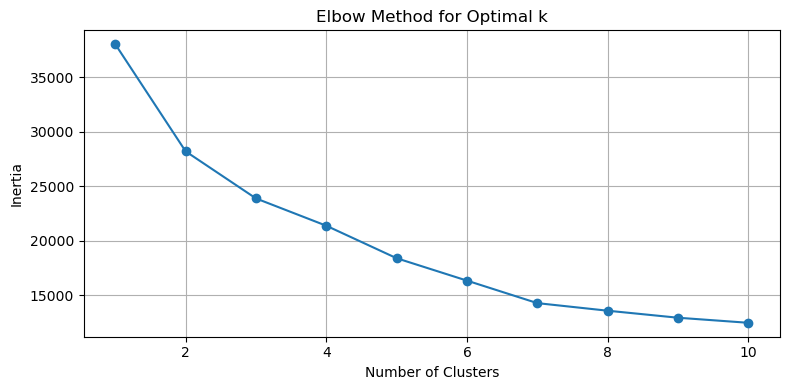

In [193]:
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

Look at the plot, we can see that the elbow point at 4 clusters is quite enough for clustering although the rate of the inertia decrease is more steep after that than higher numbers of clusters.

#### 4. Apply KMeans clustering algorithm

Now we can apply the KMeans clustering algorithm to the standardized data. We will use the `KMeans` class from the `sklearn.cluster` module to do this. The `KMeans` class takes the number of clusters as input and returns a KMeans object.

We will set the number of clusters to 4, which is the optimal number of clusters we determined earlier. We also set the `random_state` parameter to 42 to ensure that the results are reproducible.

Finally, we create a new column called `cluster` in the `cluster_data` DataFrame to store the cluster labels assigned by the KMeans algorithm. The `fit_predict()` method is used to assign each data point to a cluster based on the fitted model.

In [196]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_data_scaled)

cluster_data['cluster'] = cluster_labels


After that, we can observe the number of samples in each cluster using the `value_counts()` method.

In [198]:
cluster_counts = cluster_data['cluster'].value_counts().sort_index()
print("\nSamples per cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} samples ({count/len(cluster_data):.1%})")



Samples per cluster:
Cluster 0: 1960 samples (30.9%)
Cluster 1: 2397 samples (37.8%)
Cluster 2: 1033 samples (16.3%)
Cluster 3: 947 samples (14.9%)


The output shows the number of samples in each cluster. Here the cluster 2 has the most samples (37.8%), while cluster 4 has the least samples (14.9%).

Now we group the data by cluster and calculate the average of all numeric columns. This will help us understand the characteristics of each cluster and identify any significant trends or patterns.

In [200]:
cluster_profiles = cluster_data.groupby('cluster').agg({
    'age': 'mean',
    'bmi': 'mean',
    'glycohemoglobin': 'mean',
    'active_min': 'mean',
    'k_calories': 'mean',
    'has_diabetes': 'mean'
}).reset_index()


After that, display the table that shows the average of all numeric columns for each cluster.

In [202]:
display(cluster_profiles)

,cluster,age,bmi,glycohemoglobin,active_min,k_calories,has_diabetes
0,0,32.418878,25.774551,5.242051,262.672643,2146.577551,0.001020
1,1,66.320401,27.211523,5.571231,299.758220,1912.766458,0.001669
2,2,62.851888,32.663291,7.413320,244.443300,1903.770571,1.000000
3,3,46.620908,40.669377,5.540781,213.136323,1857.451954,0.011616


#### 5. Data Visualization for clusters' characteristics

For the data visualization of the grouped data, we will use the `vbar()` method to create a vertical bar plot. The vertical bar plot will show the average of each numeric column for each cluster. First, define the dropdown menu for different numeric columns to select from.

In [204]:
feature = Dropdown(
    options= cluster_vars,
    value='has_diabetes',
    description='Feature:',
)

Now we will implement the function to plot the data we grouped by cluster. The function will take the selected numeric column as input and plot the average of that column for each cluster.

Finally, we will call the function with the @interact decorator to show the interactive plot. The `interact` function will call the dropdown menu for each column we defined earlier.

In [206]:
@interact(feature=feature)
def plot_cluster_profiles(feature):
    clusters = [f'Cluster {i}' for i in cluster_profiles['cluster']]
    values = cluster_profiles[feature]
    
    p = figure(
        title=f'Average {feature} by Cluster',
        x_range=clusters,
        height=400, width=600
    )
    
    bars = p.vbar(x=clusters, top=values, width=0.5)
    
    p.xaxis.axis_label = "Cluster"
    p.yaxis.axis_label = feature
    p.y_range.start = 0
    
    show(p)

interactive(children=(Dropdown(description='Feature:', index=5, options=('age', 'bmi', 'glycohemoglobin', 'act…

The four clusters exhibits distinct characteristics of age, BMI, glycohemoglobin, physical activity, estimated energy intake, and standard public-health cut-offs for diabetics diagnosis.

**Cluster 0 – “Young & Active Low-Risk”**

Participants average 33 years old with a BMI of 28.7 kg/m²—technically just into the “overweight” band but still below the obesity threshold. Their mean glycohemoglobin of 5.28% sits well inside the non-diabetic range (< 5.7%), and the model reports a virtually null probability of diabetes (0.1%). Despite a daily energy intake of roughly 2,100 kcal, they accumulate roughly 210 active minutes per week (well above the 150 min/week guideline), which likely offsets caloric surplus. This cluster represents a metabolically resilient, physically active young cohort with minimal glycaemic burden.

**Cluster 1 – “Fit Retirees With Stable Glycaemia”**

At 65 years, these adults are the oldest non-diabetic group. Their BMI (29.3 kg/m²) mirrors Cluster 0, but the slightly higher glycohemoglobin level (5.58%) still falls under the pre-diabetes cut-off. They remain physically engaged (221 active minutes per week) while consuming a modest amount of 1,890 kcal/day. Diabetes prevalence is again negligible (0.04 %). This cluster is older but health-conscious, whose activity level appears to preserve normal glycaemic control despite age-related risk.

**Cluster 2 – “Middle-Aged, Very Active, Emerging Dysglycaemia”**

This group, with a mean age of 53 years, presents an intriguing mix: a near-overweight BMI (28.9 kg/m²), glycohemoglobin of 5.69% (right at the pre-diabetes threshold), and an exceptional 2,004 active minutes, much higher than the other clusters. Energy intake (2,036 kcal) is modest, yet 12.5% have already been diagnosed with diabetes. Thus, they are extremely active adults whose high activity may be compensatory—perhaps exercising in response to incipient metabolic risk—but a sizeable minority are tipping into diabetes.

**Cluster 3 – “Older, Obese, Overt Diabetes”**

Members average 62 years with an obese BMI (32.9 kg/m²) and markedly elevated glycohemoglobin (7.40%), firmly in the diabetic range (≥ 6.5 %). Despite activity levels comparable to Clusters 0 & 1 (roughly 207 min), every individual in this cluster is diabetic (100 % prevalence).  Caloric intake (1,904 kcal) is only moderate, suggesting that weight and glycaemic status reflect long-term energy imbalance and insulin resistance rather than current diet alone. This cluster is a high-risk metabolic profile—older, clinically obese, and universally diabetic—underscoring the need for targeted intervention.

#### 6. PCA for dimensionality reduction

As mentioned above, we will apply PCA to reduce the dimensionality of the data after cluster analysis. This will help visualize the clusters in a lower-dimensional space instead of generating a bar plot for each variable in the previous section.

##### a. Apply PCA
Firstly, we will use the `PCA` class from the `sklearn.decomposition` module to do this. The `PCA` class takes the number of components as input and returns a PCA object. This class will perform the PCA transformation on the data and return the transformed data. We set the number of components to 2 because we want to reduce the data to 2 dimensions.

For the PCA transformation, we will use the `fit_transform()` method to fit the model to the data and transform the data into 2 dimensions. The transformed data will be stored in a new DataFrame called `pca_result`, which will contain the PCA components for each data point.

We will then create a new DataFrame called `cluster_viz_data` to store the PCA components and cluster labels. The `cluster_viz_data` DataFrame will contain the following columns:
- `cluster`: The cluster label assigned by the KMeans algorithm
- `pca1`: The first PCA component
- `pca2`: The second PCA component

In [209]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_data_scaled)

cluster_viz_data = cluster_data.copy()
cluster_viz_data['pca1'] = pca_result[:, 0]
cluster_viz_data['pca2'] = pca_result[:, 1]

print(f"PCA explained variance\n"
      f"PC1: {pca.explained_variance_ratio_[0]:.2%},\n"
      f"PC2: {pca.explained_variance_ratio_[1]:.2%},\n"
      f"Total: {sum(pca.explained_variance_ratio_):.2%}")

pc_components = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=cluster_vars
)
display(pc_components)

PCA explained variance
PC1: 31.82%,
PC2: 17.14%,
Total: 48.96%


,PC1,PC2
age,0.363575,0.190470
bmi,0.283112,-0.421662
glycohemoglobin,0.624326,0.091743
active_min,-0.022949,0.843758
k_calories,-0.086770,0.250249
has_diabetes,0.624357,0.054340


As you can see, the two PCA components explain 48.96% of the variance in the data, which is quite good for visualization. This percentage represents the proportion of variance explained by each principal component. The first principal component (PC1) explains 31.82% of the variance, while the second principal component (PC2) explains 17.14% of the variance.

Elevated scores on PC1 correlate with increased glycohemoglobin levels, diagnosed diabetes, advanced age, and, to a lesser extent, elevated BMI. Because the two diabetes‑related variables dominate, the axis is best read as a “glycaemic‑metabolic burden” dimension. Moving right along PC1 therefore means progressively older, higher BMI participants with worsening glycohemoglobin control and a higher likelihood of diagnosed diabetes.

PC2 is anchored almost exclusively by physical activity. Participants who log more active minutes per week (and, to a lesser degree, higher caloric intake consistent with that activity) score high on this axis, whereas those with greater BMI but lower activity fall to the bottom. In short, PC2 represents an “activity–adiposity balance”. Individuals high on this axis are physically active, consume slightly more calories, and—interestingly—tend to have lower BMI despite the extra intake. Sedentary, heavier participants fall lower on PC 2.

##### b. Data Visualization for PCA components

Now we can visualize the PCA components using a scatter plot. The scatter plot will show the PCA components for each data point, colored by their cluster labels.

Like all plot sections, we will create two dropdown menus for different categorical variables to select from. The first dropdown menu will allow us to select the first principle component, with other original variables, while the second dropdown menu will allow us to select the second principle component, with other original variables.


In [212]:
feature_x = Dropdown(
    options=['pca1'] + cluster_vars,
    value='pca1',
    description='X-Axis:',
    style={'description_width': 'initial'}
)
feature_y = Dropdown(
    options=['pca2'] + cluster_vars,
    value='pca2',
    description='Y-Axis:',
    style={'description_width': 'initial'}
)


The scatter plot will be created using the `scatter()` method. By default, the scatter plot will show the PCA components for each data point, colored by their cluster labels. The `color` parameter specifies the colors for each cluster.

Finally, we will call the function with the @interact decorator to show the interactive plot. The `interact` function will call the dropdown menu for each column we defined earlier.

In [214]:
@interact(x_feature=feature_x, y_feature=feature_y)
def plot_clusters(x_feature, y_feature):
    source = ColumnDataSource(data={
        'x': cluster_viz_data[x_feature],
        'y': cluster_viz_data[y_feature],
        'cluster': cluster_viz_data['cluster'].astype(str),
        'diabetes': cluster_viz_data['has_diabetes'].astype(str),
        'age': cluster_viz_data['age'],
        'bmi': cluster_viz_data['bmi'],
        'glycohemoglobin': cluster_viz_data['glycohemoglobin'],
        'active_min': cluster_viz_data['active_min']
    })

    p = figure(
        title=f'Cluster Analysis: {x_feature} vs {y_feature}',
        x_axis_label=x_feature,
        y_axis_label=y_feature,
        width=700,
        height=500
    )

    colors = Category10[10][:k_optimal]
    for i, color in enumerate(colors):
        view = CDSView(filter=IndexFilter(indices=[
            j for j, c in enumerate(cluster_viz_data['cluster']) if c == i
        ]))
        p.circle(
            'x', 'y', size=8, color=color, legend_label=f'Cluster {i}',
            source=source, view=view, alpha=0.7
        )
    
    p.legend.location = "top_right"
    p.legend.click_policy = "hide"

    if x_feature == 'pca1' and y_feature == 'pca2':
        centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=cluster_vars)
        centers_pca = pca.transform(centers_df)
        center_source = ColumnDataSource(data={
            'x': centers_pca[:, 0],
            'y': centers_pca[:, 1],
            'labels': [f'C{i}' for i in range(k_optimal)]
        })
        
        p.square('x', 'y', size=12, color='black', line_width=2,
                source=center_source)
        
        labels = LabelSet(
            x='x', y='y', text='labels',
            source=center_source,
            text_font_size='12pt',
            x_offset=5, y_offset=5
        )
        p.add_layout(labels)
    
    show(p)

interactive(children=(Dropdown(description='X-Axis:', options=('pca1', 'age', 'bmi', 'glycohemoglobin', 'activ…

The PCA scatter illustrates that activity differentiates clusters vertically while metabolic severity pulls them apart horizontally. 

Cluster 0 sits low on PC2 but slightly left of center on PC1. Its position confirms a combination of modest metabolic load (low PC 1) and adequate, though not extreme, activity. Members are around 30 years old, hovering at the overweight threshold, yet maintain normal glycohemoglobin with roughly 200 minutes per week of physical activity. Their placement near the PC1 origin underscores how little glycaemic stress they carry.

Cluster 1 positions slightly higher in the PC2 axis, reflecting the second‑highest activity loading in the sample. Horizontally, they anchor near the PC1 midpoint, signaling minimal glycohemoglobin disturbance despite aging, on average, 65 years old. In essence, their exceptional activity keeps them metabolically comparable to Cluster 0, even though they are three decades older.

Cluster 2 overlaps the left half of Cluster 0 but rises on PC2, indicating that a share of these highly active 50-year-olds are still wrestling with glycohemoglobin drift. Their glycohemoglobin level sits on the pre‑diabetic line, and 12% are diagnosed, so they populate a transitional band: plenty of exercise, BMI just under 30, but beginning metabolic strain pulls them rightward along PC1.

Cluster 3 dominates the far‑right quadrant, its centroid more than two PC1 units beyond any other group, which expresses pronounced hyperglycemia, universal diabetes, and obesity based on the BMI index. Activity scores are average, so points lie near the PC2 mid‑line: lifestyle alone no longer offsets long‑standing insulin resistance. This separation makes Cluster 3 the map’s clinical hot spot, meriting intensive weight and glucose‑control programs.

Other analysis of clusters with any pair of variables - PCA1, PCA2, age, BMI, glycohemoglobin, active minutes per week, total calories intake, and diabetes diagnosis - can be accessed using the dropdown for x- and y-axis.

## VI. Conclusion


This report integrated seven NHANES 2021-2023 component files to construct a unified diabetes risk assessment dataset. The methodology employed KNN imputation to minimize data loss and conducted risk analysis through exploratory data analysis, supervised modeling, and unsupervised clustering techniques. The findings demonstrate internal consistency, revealing that age and body mass index constitute the primary determinants of diabetes risk. At the same time, socioeconomic factors and lifestyle behaviors significantly modify these baseline associations.

Diabetes prevalence climbs step‑wise with age and BMI. Notably, Non-Hispanic Black adults exhibited the highest disease burden across demographic groups, highlighting persistent health disparities that extend beyond individual physiological factors and reflect broader structural inequities within the healthcare system. The random forest classification model demonstrated that an efficient two-stage screening protocol utilizing age and BMI as initial parameters, followed by targeted dietary and physical activity assessments, could effectively identify high-risk individuals while maintaining an acceptable false positive rate.

The income stratification analysis provided particularly compelling evidence that economic disadvantage confers independent diabetes risk that persists even after controlling for body weight. This finding suggests that factors such as food security, chronic psychosocial stress, and healthcare access represent critical intervention targets beyond traditional weight management approaches. The unsupervised learning techniques, including K-means clustering and principal component analysis, successfully distilled these complex relationships into four distinct risk profiles, providing a practical framework for tailoring public health interventions and clinical care protocols. PCA further collapsed the metrics into two intuitive axes — metabolic severity and lifestyle activity — that cleanly map those clusters, simplifying communication to stakeholders.

The analysis has several methodological strengths that enhance the validity and applicability of its findings. The use of NHANES sampling weights ensures that the results are generalizable to the broader U.S. adult population, addressing a common limitation in diabetes risk research. The `bokeh` library has facilitated the creation of interactive visualizations, effectively presenting the data. Additionally, the application of multiple analytical methods provides robust evidence for the identified risk factors, increasing confidence in the study's conclusions.

Several limitations must be acknowledged when interpreting these findings. The cross-sectional nature of the NHANES data precludes establishing temporal relationships or causal pathways among age, BMI, income, and diabetes outcomes. Longitudinal studies would be necessary to confirm the directionality of these associations and their evolution over time. The reliance on self-reported measures introduces potential measurement bias, as participants may be under certain response bias. Future research incorporating objective accelerometer data from NHANES subsamples would provide more accurate activity assessments. The socioeconomic analysis was constrained by the use of a coarse three-category poverty level index, limiting the granularity of equity-related findings. More detailed socioeconomic indicators, including educational attainment, food security status, and neighborhood-level characteristics, would enhance understanding of social determinants of diabetes risk.

The findings have direct implications for clinical practice, public health policy, and program implementation. In clinical settings, the validated two-stage screening approach using age and BMI as primary indicators, supplemented by brief dietary and physical activity assessments, offers an efficient method for identifying high-risk patients while minimizing clinical workflow burden. From a policy perspective, the demonstration of income-related diabetes risk independent of body weight argues for expanding prevention funding beyond traditional weight management programs to include food access initiatives and primary care strengthening in economically disadvantaged communities.

The four distinct risk clusters identified through unsupervised learning provide actionable targets for differentiated intervention strategies. Young, physically active adults require motivation and support to maintain healthy behaviors over time. Physically fit seniors would benefit from targeted dietary counseling and nutritional optimization. Highly active middle-aged individuals represent a critical prevention opportunity, requiring engagement before glycemic parameters deteriorate. The obese-diabetic cluster necessitates intensive, coordinated interventions addressing both weight management and glucose control.

In summary, this analysis confirms established diabetes risk factors while revealing the independent contribution of socioeconomic disadvantage beyond traditional physiological markers. The interactive analytical tools and evidence-based risk profiles provide a foundation for both individual clinical decision-making and population-level resource allocation strategies in diabetes prevention and management.